In [3]:
from itertools import product

In [4]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [5]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [6]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)

In [7]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros((16,) + total_seeds.shape, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            if block_idx % 2 == 0:
                for k in range(16):
                    block = [0] * BLOCK_WIDTH_B4
                    block[block_idx] = (k + whitening[keyround_target_idx]) % 16

                    sbox_in = block[block_idx]
                    sbox_out = s_boxes_b4[block_idx][sbox_in]

                    hypotheses[k][i] = HW[sbox_out]
            else:
                raise ValueError("Should not happen")

            location_mask_per_trace[i][locations[round_idx][block_idx]] = True

    return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]

Key 0: 

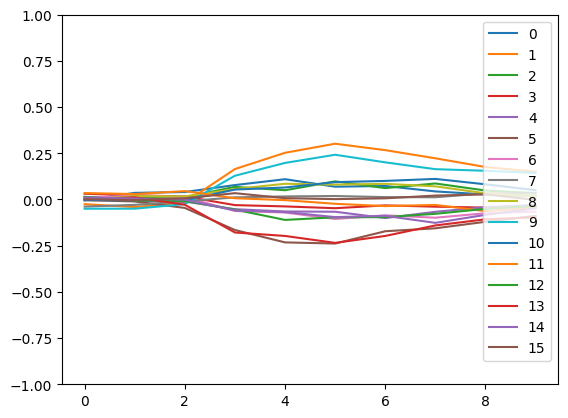

1[ 0.10960496  0.30169521  0.0980122   0.03098991  0.01305762 -0.00370739
  0.0223105   0.03311447  0.08503595  0.24201271  0.11129552  0.04535318
  0.01433394  0.0117986   0.01033939  0.03409246]


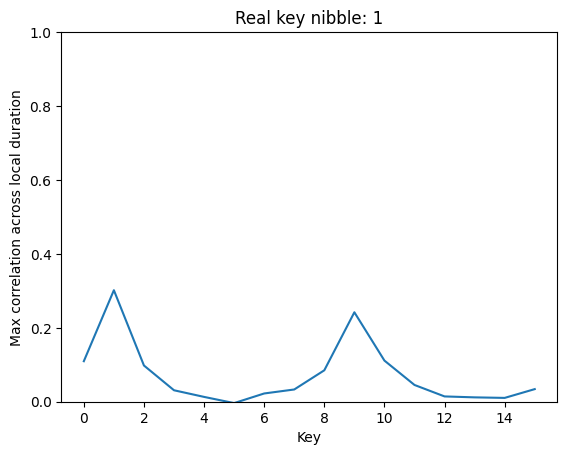

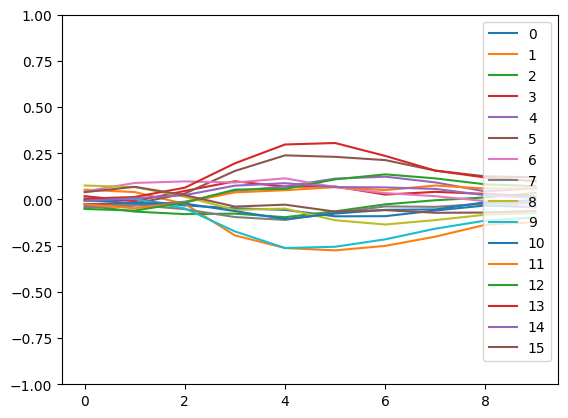

D[-0.00265111  0.05307226  0.0351219   0.0984216   0.12333685  0.23879073
  0.11441979 -0.0180418   0.07553938  0.00420295 -0.00381275  0.07554809
  0.13591009  0.30555221  0.08804267  0.06846279]


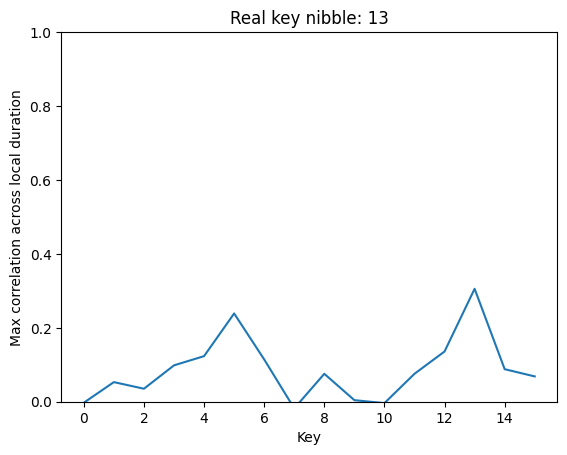

KeyboardInterrupt: 

In [10]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    for j in range(reconstructed_keys.shape[1]):
        selected_traces, hypotheses = indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(j, 4, seeds[i], traces[i], correlation_locations)
        corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])

        for l in range(len(corrs)):
            plt.plot(corrs[l], label=str(l))

        plt.ylim([-1, 1])
        plt.legend()
        plt.show()
        
        max_corrs = np.max(corrs, axis=1)
        best_k = np.argmax(max_corrs)
        reconstructed_keys[i][j] = best_k

        print(hex(best_k)[2:].upper(), end="")

        print(max_corrs)
        plt.plot(max_corrs)
        plt.xlabel("Key")
        plt.ylabel("Max correlation across local duration")
        plt.title(f"Real key nibble: {real_keys[i][j]}")
        plt.ylim([0, 1])
        plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()